# Loading Packages and Data:
---

In [2]:
import pandas as pd
import requests

from fcd_torch import FCD
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import time
import GPUtil

import matplotlib.pyplot as plt

In [13]:
filename = '/mnt/usb/cmdunham/BKG_SIM_ims_acbc_train_v1.1.09_meta.feather'
metadata = pd.read_feather(filename)

filename = '/mnt/usb/cmdunham/BKG_SIM_ims_acbc_train_v1.1.09_spectra.feather'
spectra = pd.read_feather(filename)

In [6]:
filename = '../../../../mnt/c/Users/cmdunham/OneDrive/Documents/phd_program/ChemicalDataGeneration/data/BKG_SIM_ims_acbc_train_v1.1.09_spectra.feather'
spectra = pd.read_feather(filename)

In [2]:
# filename = '../../../../mnt/c/Users/cmdunham/OneDrive/Documents/phd_program/ChemicalDataGeneration/data/ims_data/train_data.feather'
# train_spectra = pd.read_feather(filename)
# filename = '../../../../mnt/c/Users/cmdunham/OneDrive/Documents/phd_program/ChemicalDataGeneration/data/ims_data/test_data.feather'
# test_spectra = pd.read_feather(filename)
filename = '../../../../mnt/c/Users/cmdunham/OneDrive/Documents/phd_program/ChemicalDataGeneration/data/ims_data/val_data.feather'
val_spectra = pd.read_feather(filename)

# Getting Simulant Names/SMILES:
---

In [3]:
labels = list(metadata['Label'].unique())
labels

['BKG', 'DEM', 'DEB', 'MES', 'DMMP', 'DPM', 'TEPO', 'JP8', 'DtBP']

In [31]:
simulant_name_mapping = {'BKG':{'Name':'Background', 'SMILES':'NA'}, 'DEM':{'Name': 'Diethyl Malonate'}, 'DEB':{'Name': '1,2,3,4-Diepoxybutane' }, 
                         'MES':{'Name': '2-(N-morpholino)ethanesulfonic acid'}, 'DMMP':{'Name': 'Dimethyl methylphosphonate'}, 'DPM':{'Name': 'Oxybispropanol'}, 
                         'JP8':{'Name': 'JP8'}, 'TEPO':{'Name': 'Triethyl phosphate', 'SMILES': 'CCOP(=O)(OCC)OCC'},'DtBP':{'Name': 'Di-tert-butyl peroxide', 'SMILES': 'O(OC(C)(C)C)C(C)(C)C'}}
names = []
for key in simulant_name_mapping:
    names.append(simulant_name_mapping[key]['Name'])


In [32]:
for abbreviation in simulant_name_mapping:
    name = simulant_name_mapping[abbreviation]['Name']
    try:
        # send simulant name to PubChem's API and get SMILES out of response
        url = (f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/property/CanonicalSMILES/JSON')
        r = requests.get(url).json()
        smiles = r['PropertyTable']['Properties'][0]['CanonicalSMILES']
        simulant_name_mapping[abbreviation]['SMILES'] = smiles

    except KeyError as e:
        try:
            # send simulant abbreviation to PubChem's API and get SMILES out of response
            url = (f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{abbreviation}/property/CanonicalSMILES/JSON')
            r = requests.get(url).json()
            smiles = r['PropertyTable']['Properties'][0]['CanonicalSMILES']
            simulant_name_mapping[abbreviation]['SMILES'] = smiles
        except KeyError as e:
            if e == 'PropertyTable':
                simulant_name_mapping[abbreviation]['SMILES'] = 'unknown'

simulant_name_mapping

{'BKG': {'Name': 'Background', 'SMILES': 'NA'},
 'DEM': {'Name': 'Diethyl Malonate', 'SMILES': 'CCOC(=O)CC(=O)OCC'},
 'DEB': {'Name': '1,2,3,4-Diepoxybutane', 'SMILES': 'C1C(O1)C2CO2'},
 'MES': {'Name': '2-(N-morpholino)ethanesulfonic acid',
  'SMILES': 'C1COCCN1CCS(=O)(=O)O'},
 'DMMP': {'Name': 'Dimethyl methylphosphonate', 'SMILES': 'COP(=O)(C)OC'},
 'DPM': {'Name': 'Oxybispropanol', 'SMILES': 'CC(CO)OC(C)CO.CC(COCC(C)O)O'},
 'JP8': {'Name': 'JP8', 'SMILES': 'C1CC(NC1)COC(=O)NC2CCC(=O)NC2=O'},
 'TEPO': {'Name': 'Triethyl phosphate', 'SMILES': 'CCOP(=O)(OCC)OCC'},
 'DtBP': {'Name': 'Di-tert-butyl peroxide', 'SMILES': 'CC(C)(C)OOC(C)(C)C'}}

In [3]:
def get_chemnet_emb_from_name(name_list):
    name_mapping = {}
    for name in name_list:
        name_mapping[name] = {}
        try:
            # send simulant name to PubChem's API and get SMILES out of response
            url = (f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/property/CanonicalSMILES/JSON')
            r = requests.get(url).json()
            smiles = r['PropertyTable']['Properties'][0]['CanonicalSMILES']
            name_mapping[name]['SMILES'] = smiles
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            fcd = FCD(device, n_jobs=1)
            name_mapping[name]['embedding'] = list(fcd.get_predictions([smiles])[0])
        except KeyError as e:
            if e == 'PropertyTable':
                name_mapping[name]['SMILES'] = 'unknown'

    return name_mapping

In [4]:
mass_spec_names = ['(5R,11R)-5,11-Dimethylpentacosane', '1,3-Diaminopropane', '1,4-Butanediamine', '1-Hexanol', '1-Octanol', '2-Octanol',
 '4-Hydroxyphenylpyruvic Acid', 'Allantoin', 'Anthracene', 'Benzoic Acid', 'Benzyl Alcohol', 'Benzyl Benzoate', 'Beta-Alanine', 'Biphenyl',
 'Caffeine', 'Ethanolamine', 'Fluorene', 'Fumaric Acid', 'Gamma-Amino-N-Butyric Acid', 'Glutaric Acid', 'Glycerol', 'Glycine', 'Glycylglycine',
 'Hexachlorobenzene', 'Isopentyl Acetate', 'L-Alanine', 'L-Asparagine', 'L-Aspartic Acid', 'L-Glutamine', 'L-Leucine', 'L-Lysine', 'L-Norleucine',
 'L-Ornithine', 'L-Serine', 'L-Tyrosine', 'L-Valine', 'Lauric Acid', 'Malonic Acid', 'Methyl Benzoate', 'Methyl Hexanoate', 'Methyl Octadecanoate',
 'Naphthalene', 'Pentadecane', 'Phenanthrene', 'Pyrene', 'Spermidine', 'Succinic Acid', 'Testosterone', 'Tryptophan', 'Undecane'] 
 
mass_spec_name_mapping = get_chemnet_emb_from_name(mass_spec_names)

# Getting Simulant ChemNet Embeddings:
---

In [36]:
# Get ChemNet embeddings from simulant SMILES
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fcd = FCD(device, n_jobs=1)
for abbreviation in simulant_name_mapping:
    if abbreviation != 'BKG':
        smiles = simulant_name_mapping[abbreviation]['SMILES']
        simulant_name_mapping[abbreviation]['embedding'] = list(fcd.get_predictions([smiles])[0])

# Saving Background, Spectra and Embedding Files:
---

## Background:
---

In [7]:
# Remove all simulant spectra, leave only background
bkg = spectra[spectra['Label'] == 'BKG']
bkg.head()

,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,p_192,...,n_1013,n_1014,n_1015,n_1016,n_1017,n_1018,n_1019,n_1020,n_1021,Label
0,1427,92.0,94.0,98.0,101.0,106.0,110.0,117.0,121.0,127.0,...,-11.0,-11.0,-11.0,-8.0,-8.0,-7.0,-7.0,-7.0,-7.0,BKG
1,1452,85.0,87.0,92.0,98.0,103.0,110.0,116.0,123.0,127.0,...,-13.0,-14.0,-17.0,-18.0,-19.0,-20.0,-17.0,-17.0,-17.0,BKG
2,1467,86.0,91.0,97.0,103.0,109.0,115.0,120.0,125.0,130.0,...,-18.0,-18.0,-22.0,-22.0,-24.0,-23.0,-23.0,-23.0,-21.0,BKG
3,1486,97.0,98.0,102.0,104.0,107.0,110.0,114.0,117.0,121.0,...,-27.0,-26.0,-26.0,-22.0,-21.0,-22.0,-23.0,-23.0,-27.0,BKG
4,1564,91.0,96.0,101.0,105.0,112.0,117.0,121.0,125.0,128.0,...,-14.0,-17.0,-18.0,-21.0,-21.0,-19.0,-18.0,-17.0,-16.0,BKG


In [12]:
# # resetting index to get around: "feather does not support serializing a non-default index for the index;"
# bkg = bkg.reset_index()
file_path = '../data/bkg.feather'
bkg.to_feather(file_path)

In [8]:
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/bkg.csv'
# bkg.to_csv(file_path, index=False)

## Spectra:
---

In [14]:
# Remove all background spectra, leave only simulants
simulants = spectra[spectra['Label'] != 'BKG']

# Create OneHot encodings of chem abbreviations
enc = OneHotEncoder(sparse_output=False)
encodings = enc.fit_transform(simulants[['Label']])

# get chemical abbreviations from enc.categories
columns = [abbr for abbr in enc.categories_[0]]
# create encoding df 
encoding_df = pd.DataFrame(encodings, columns=columns)

In [15]:
# dropping indices so concatenation works correctly  
simulants.reset_index(drop=True, inplace=True)
encoding_df.reset_index(drop=True, inplace=True)

# concatenate simulants and encoding df
spectra_and_encodings = pd.concat([simulants, encoding_df], axis=1)
spectra_and_encodings.head()

,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,p_192,...,n_1021,Label,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,316161,99.0,103.0,106.0,111.0,116.0,121.0,125.0,130.0,136.0,...,-26.0,MES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,316163,83.0,87.0,92.0,95.0,100.0,104.0,109.0,114.0,120.0,...,8.0,MES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,316164,91.0,95.0,97.0,101.0,107.0,113.0,120.0,128.0,134.0,...,7.0,MES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,316165,87.0,91.0,95.0,99.0,103.0,107.0,111.0,119.0,126.0,...,-13.0,MES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,316166,75.0,79.0,82.0,87.0,94.0,100.0,107.0,112.0,118.0,...,-2.0,MES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
# divide into train and test data
train_val, test = train_test_split(spectra_and_encodings, test_size=.2, random_state = 22)
# divide train into train and validation data
train, val = train_test_split(train_val, test_size=.25, random_state=22)

print(train.shape, val.shape, test.shape)

(222519, 1686) (74173, 1686) (74173, 1686)


In [17]:
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_data.csv'
train.to_csv(file_path)

file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_data.csv'
val.to_csv(file_path)

file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/test_data.csv'
test.to_csv(file_path)

## Embeddings:
---

In [37]:
name_smiles_embedding_df = pd.DataFrame(simulant_name_mapping).T
name_smiles_embedding_df.head()

,Name,SMILES,embedding
BKG,Background,NA,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809719, 0.0005454039, 0.25539753, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318759, 0.009022221, 0.42160067, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520813, 0.009838342, -0.15108328, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106821, 0.0029424396, -0.14450483, 0.0726..."


In [ ]:
# save df with chem names, smiles and ChemNet embeddings
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/name_smiles_embedding_file.csv'
file_path = '../data/name_smiles_embedding_file.csv'
name_smiles_embedding_df.to_csv(file_path)

In [8]:
mass_spec_name_mapping_df = pd.DataFrame(mass_spec_name_mapping).T
mass_spec_name_mapping_df['Name'] = list(mass_spec_name_mapping_df.index)
mass_spec_name_mapping_df.head()

,SMILES,embedding,Name
"(5R,11R)-5,11-Dimethylpentacosane",CCCCCCCCCCCCCCC(C)CCCCCC(C)CCCC,"[-0.048933726, 0.0017029907, -0.272093, -0.369...","(5R,11R)-5,11-Dimethylpentacosane"
"1,3-Diaminopropane",C(CN)CN,"[-0.22048391, -0.0011410714, 0.06557533, 0.193...","1,3-Diaminopropane"
"1,4-Butanediamine",C(CCN)CN,"[-0.21609126, -0.0005372154, 0.24562673, 0.293...","1,4-Butanediamine"
1-Hexanol,CCCCCCO,"[-0.23157702, 0.0011296304, 0.21073784, -0.179...",1-Hexanol
1-Octanol,CCCCCCCCO,"[-0.2599937, 0.0021180445, 0.109357715, -0.293...",1-Octanol


In [9]:
file_path = '../data/mass_spec_name_smiles_embedding_file.csv'
mass_spec_name_mapping_df.to_csv(file_path)

# Generating CARLs:
---

In [3]:
if torch.cuda.is_available():
    # Get the list of GPUs
    gpus = GPUtil.getGPUs()

    # Find the GPU with the most free memory
    best_gpu = max(gpus, key=lambda gpu: gpu.memoryFree)

    # Print details about the selected GPU
    print(f"Selected GPU ID: {best_gpu.id}")
    print(f"  Name: {best_gpu.name}")
    print(f"  Memory Free: {best_gpu.memoryFree} MB")
    print(f"  Memory Used: {best_gpu.memoryUsed} MB")
    print(f"  GPU Load: {best_gpu.load * 100:.2f}%")

    # Set the device for later use
    device = torch.device(f'cuda:{best_gpu.id}')
    print('Current device ID: ', device)

    # Set the current device in PyTorch
    torch.cuda.set_device(best_gpu.id)
else:
    device = torch.device('cpu')
    print('Using CPU')

# Confirm the currently selected device in PyTorch
print("PyTorch current device ID:", torch.cuda.current_device())
print("PyTorch current device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Selected GPU ID: 0
  Name: NVIDIA GeForce RTX 4060 Laptop GPU
  Memory Free: 7957.0 MB
  Memory Used: 0.0 MB
  GPU Load: 0.00%
Current device ID:  cuda:0
PyTorch current device ID: 0
PyTorch current device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/bkg.csv'
background = pd.read_csv(file_path)

file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_data.csv'
train = pd.read_csv(file_path)

file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_data.csv'
val = pd.read_csv(file_path)

file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/test_data.csv'
test = pd.read_csv(file_path)

In [12]:
file_path = '../data/BKG_SIM_ims_acbc_train_v1.1.09_spectra.feather'
spectra = pd.read_feather(file_path)

# Remove all simulant spectra, leave only background
background = spectra[spectra['Label'] == 'BKG']
# remove spectra df from memory
del spectra
background.head()

,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,p_192,...,n_1013,n_1014,n_1015,n_1016,n_1017,n_1018,n_1019,n_1020,n_1021,Label
0,1427,92.0,94.0,98.0,101.0,106.0,110.0,117.0,121.0,127.0,...,-11.0,-11.0,-11.0,-8.0,-8.0,-7.0,-7.0,-7.0,-7.0,BKG
1,1452,85.0,87.0,92.0,98.0,103.0,110.0,116.0,123.0,127.0,...,-13.0,-14.0,-17.0,-18.0,-19.0,-20.0,-17.0,-17.0,-17.0,BKG
2,1467,86.0,91.0,97.0,103.0,109.0,115.0,120.0,125.0,130.0,...,-18.0,-18.0,-22.0,-22.0,-24.0,-23.0,-23.0,-23.0,-21.0,BKG
3,1486,97.0,98.0,102.0,104.0,107.0,110.0,114.0,117.0,121.0,...,-27.0,-26.0,-26.0,-22.0,-21.0,-22.0,-23.0,-23.0,-27.0,BKG
4,1564,91.0,96.0,101.0,105.0,112.0,117.0,121.0,125.0,128.0,...,-14.0,-17.0,-18.0,-21.0,-21.0,-19.0,-18.0,-17.0,-16.0,BKG


In [3]:
file_path = '../data/ims_data/train_data.feather'
train = pd.read_feather(file_path)

file_path = '../data/ims_data/val_data.feather'
val = pd.read_feather(file_path)

file_path = '../data/ims_data/test_data.feather'
test = pd.read_feather(file_path)

In [87]:
# def plot_spectra(spectra, label='Background Spectrum', chem_labels=False):
def plot_spectra(spectra, chem_labels, carl=False):
    _, axes = plt.subplots(1, 2, figsize=(14, 8))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # if chem_label:
    #     labels = 

    for idx, row in spectra.iloc[:2,:].iterrows():
    # for idx, row in bkg_slice.iterrows():
        numbers = range(184, (len(row)//2)+184)

        axes[idx].plot(numbers, row[:len(numbers)], label='Positive')
        axes[idx].plot(numbers, row[len(numbers):], label='Negative')
        if carl:
            axes[idx].set_title(f'{chem_labels[idx]} Spectrum {idx+1} - Average BKG', fontsize=20)
        else:
            axes[idx].set_title(f'{chem_labels[idx]} Spectrum {idx+1}', fontsize=20)
        axes[idx].set_xlabel('Drift Time', fontsize=16)
        axes[idx].set_ylabel('Ion Intensity', fontsize=16)
        axes[idx].legend(fontsize=14)

    plt.tight_layout()
    plt.show()

In [39]:
def generate_differences_df(spectra_df, background_sample):
    # Convert DataFrames to PyTorch tensors
    spectra = spectra_df.iloc[:,2:-9]
    tensor1 = torch.tensor(spectra.values, dtype=torch.float32)
    tensor2 = torch.tensor(background_sample.values, dtype=torch.float32)
    # tensor1 = torch.tensor(spectra.values, dtype=torch.int8)
    # tensor2 = torch.tensor(background_sample.values, dtype=torch.int8)

    # Move tensors to GPU if available
    if torch.cuda.is_available():
        tensor1 = tensor1.cuda()
        tensor2 = tensor2.cuda()

    differences = tensor1.unsqueeze(1) - tensor2.unsqueeze(0)

    differences_np = differences.cpu().numpy()  # move differences to cpu

    # Reshape the differences to 2D for DataFrame creation
    m, p, n = differences_np.shape
    differences_reshaped = differences_np.reshape(m * p, n)

    # Create a DataFrame from the reshaped array
    differences_df = pd.DataFrame(differences_reshaped)
    # round to two decimal places
    differences_df = differences_df.astype(float).round(2)

    index_col = np.repeat(spectra_df['index'].values, p)
    differences_df.insert(0, 'index', index_col)
    label_info = pd.DataFrame(np.repeat(spectra_df.iloc[:,-9:].values, p, axis=0))
    differences_df = pd.concat([differences_df, label_info], axis=1)
    differences_df.columns = spectra_df.columns[1:]

    return differences_df

## Generating CARLs Using Different BKG for Train, Val, Test:
---

In [10]:
n=2
train_background_sample = background.sample(n=n, random_state=42).iloc[:,1:-1]
# removing train bkg spectra so they are not used in val or test
reduced_background = background.drop(train_background_sample.index)
del background
train_background_sample.reset_index(inplace=True)
train_background_sample.drop(columns=['index'], inplace=True)

# int(n/3)
val_background_sample = reduced_background.sample(n=n, random_state=42).iloc[:,1:-1]
# removing val bkg spectra so they are not used in test
reduced_background = reduced_background.drop(val_background_sample.index)
val_background_sample.reset_index(inplace=True)
val_background_sample.drop(columns=['index'], inplace=True)

test_background_sample = reduced_background.sample(n=n, random_state=42).iloc[:,1:-1]
test_background_sample.reset_index(inplace=True)
test_background_sample.drop(columns=['index'], inplace=True)

In [ ]:
file_path='/mnt/usb/cmdunham/preprocessed_ims_data/train_carls_dif_backgrounds.csv'
differences_df = generate_differences_df(train, train_background_sample)
differences_df.to_csv(file_path, index=False, header=True)

In [ ]:
file_path='/mnt/usb/cmdunham/preprocessed_ims_data/val_carls_dif_backgrounds.csv'
differences_df = generate_differences_df(val, val_background_sample)
differences_df.to_csv(file_path, index=False, header=True)

In [ ]:
file_path='/mnt/usb/cmdunham/preprocessed_ims_data/test_carls_dif_backgrounds.csv'
differences_df = generate_differences_df(test, test_background_sample)
differences_df.to_csv(file_path, index=False, header=True)

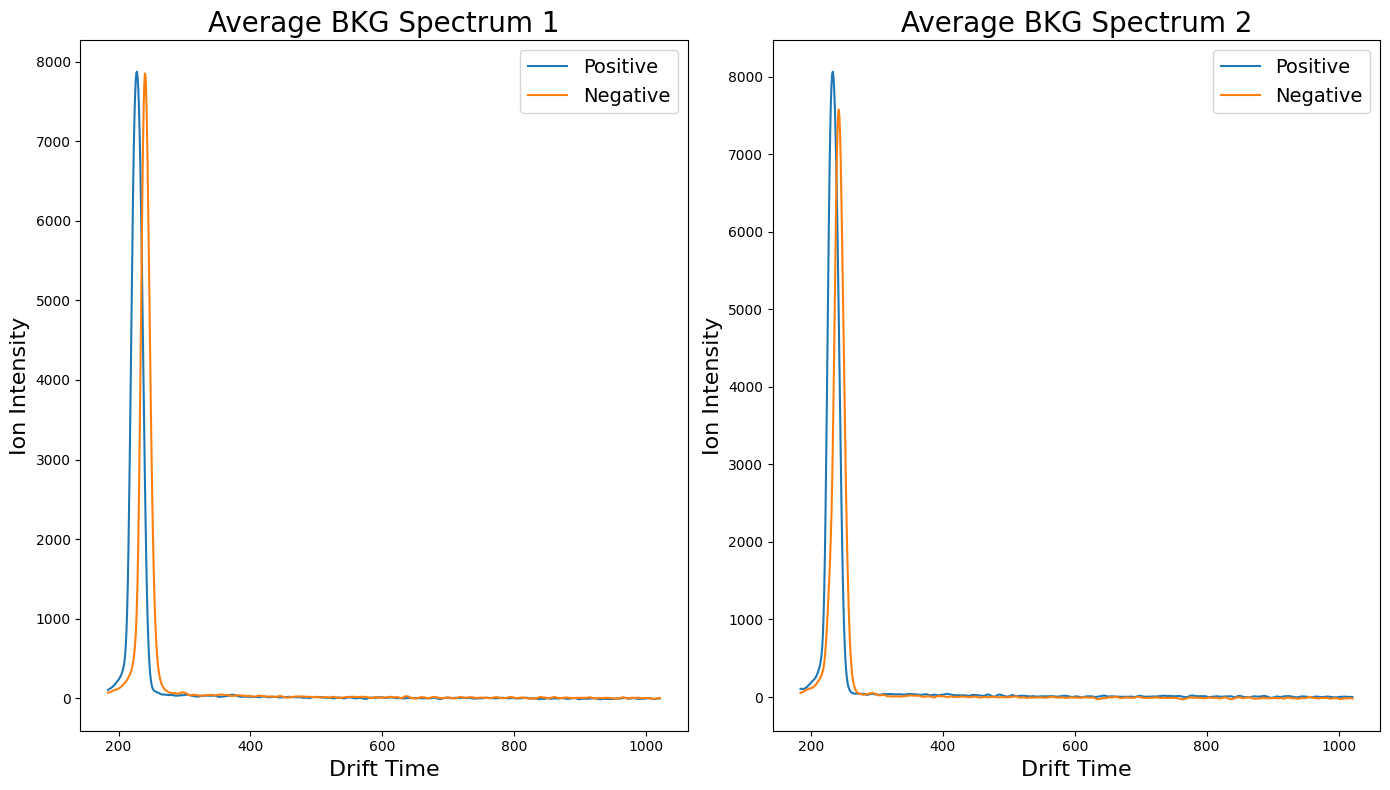

In [88]:
labels = ['Average BKG', 'Average BKG']
plot_spectra(train_background_sample, chem_labels=labels)

In [85]:
labels = train['Label']
chem = 'DtBP'
chem_indices = [index for index, element in enumerate(labels) if element == chem]
chem_indices[:10]

[19, 35, 47, 73, 94, 104, 106, 112, 120, 126]

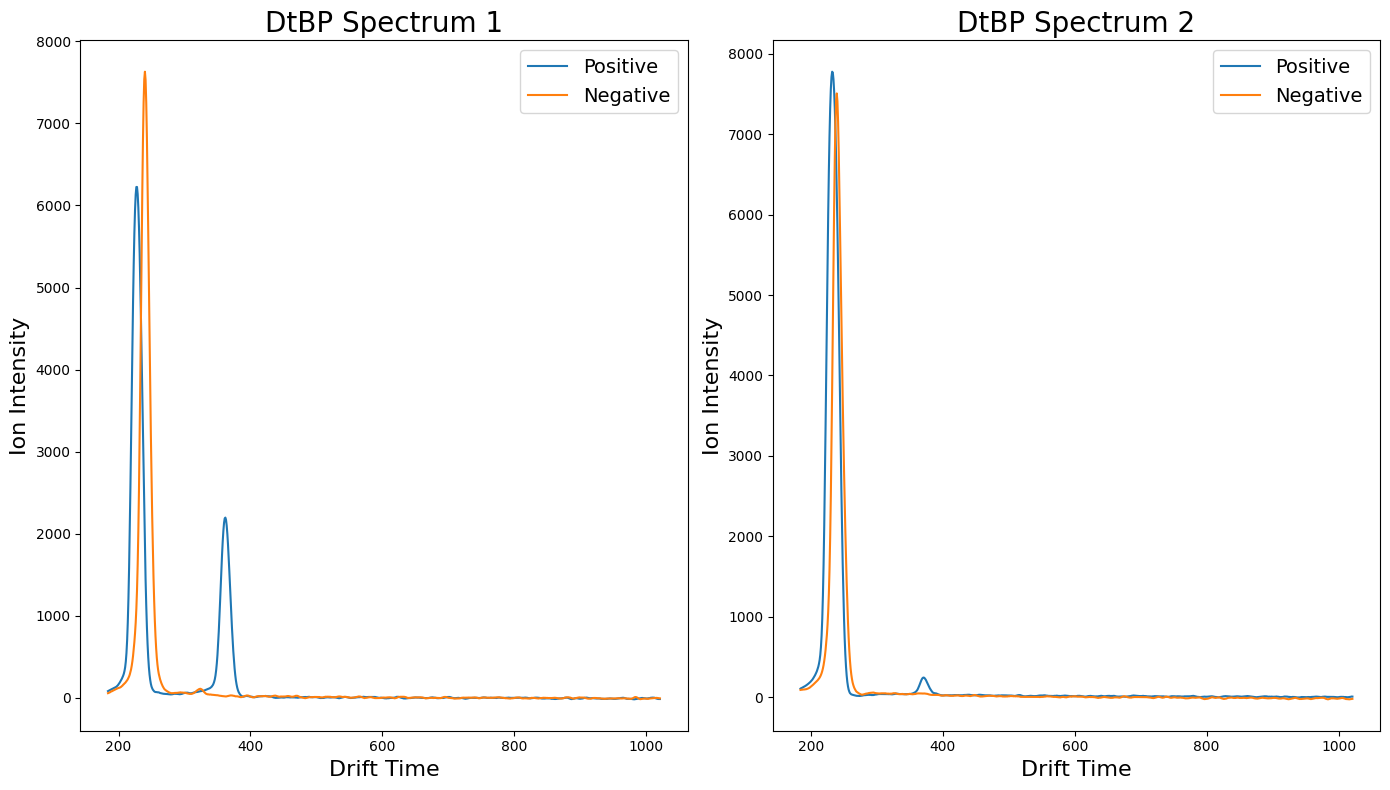

In [98]:
labels = train['Label']
idx_one = chem_indices[0]
idx_two = chem_indices[3]
dtbp_spectra = pd.concat([train.iloc[idx_one,:], train.iloc[idx_two,:]], axis=1).T.reset_index(drop=True)
labels = [labels[idx_one], labels[idx_two]]
plot_spectra(dtbp_spectra.iloc[:,2:-9], chem_labels=labels)

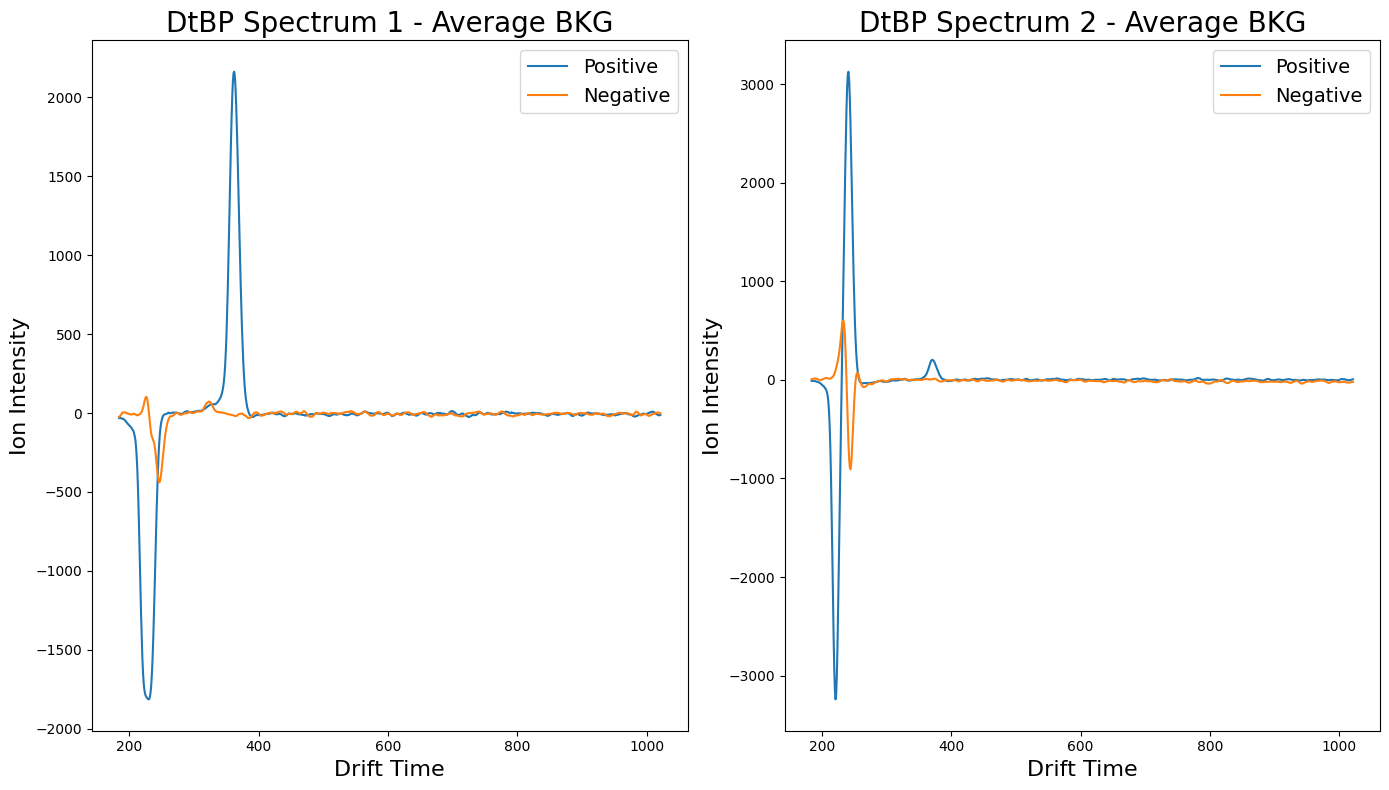

In [99]:
labels = differences_df['Label']
dtbp_carls = pd.concat([differences_df.iloc[idx_one*2,:], differences_df.iloc[idx_two*2,:]], axis=1).T.reset_index(drop=True)
labels = [labels[idx_one*2], labels[idx_two*2]]
# plot_spectra(differences_df.iloc[:,1:-9], chem_labels=labels, spec_type='CARL')
plot_spectra(dtbp_carls.iloc[:,1:-9], chem_labels=labels, carl=True)

## Generating CARLs Using Average BKG:
---
Still using different BKG for train, val, test, just using average of several BKG instead individual BKG spectra.

### Train test split BKG spectra:
---

In [2]:
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/bkg.csv'
# background = pd.read_csv(file_path)
filepath = '../data/bkg.feather'
background = pd.read_feather(filepath)

In [ ]:
# background.drop('level_0', axis=1, inplace=True)
# Train test splitting BKG spectra
train_val_bkg, test_bkg = train_test_split(background, test_size=.2, random_state = 22)
# divide train into train and validation data
train_bkg, val_bkg = train_test_split(train_val_bkg, test_size=.25, random_state=22)
del background
print(train_bkg.shape, val_bkg.shape, test_bkg.shape)

(137197, 1678) (45733, 1678) (45733, 1678)


In [13]:
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_bkg.csv'
# train_bkg.to_csv(file_path)

# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_bkg.csv'
# val_bkg.to_csv(file_path)

# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/test_bkg.csv'
# test_bkg.to_csv(file_path)

In [16]:
file_path = '../data/ims_data/train_bkg.feather'
train_bkg = train_bkg.reset_index()
train_bkg.to_feather(file_path)

file_path = '../data/ims_data/val_bkg.feather'
val_bkg = val_bkg.reset_index()
val_bkg.to_feather(file_path)

file_path = '../data/ims_data/test_bkg.feather'
test_bkg = test_bkg.reset_index()
test_bkg.to_feather(file_path)

### Load BKG spectra and create CARLs:
---

In [17]:
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_bkg.csv'
# train_bkg = pd.read_csv(file_path)

# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_bkg.csv'
# val_bkg = pd.read_csv(file_path)

# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/test_bkg.csv'
# test_bkg = pd.read_csv(file_path)

In [16]:
# filename = '../../../../mnt/c/Users/cmdunham/OneDrive/Documents/phd_program/ChemicalDataGeneration/data/ims_data/train_data.feather'
# train_spectra = pd.read_feather(filename)
# filename = '../../../../mnt/c/Users/cmdunham/OneDrive/Documents/phd_program/ChemicalDataGeneration/data/ims_data/val_data.feather'
# val_spectra = pd.read_feather(filename)
# filename = '../../../../mnt/c/Users/cmdunham/OneDrive/Documents/phd_program/ChemicalDataGeneration/data/ims_data/test_data.feather'
# test_spectra = pd.read_feather(filename)

In [54]:
# file_path = '../data/ims_data/train_data.feather'
# train = pd.read_feather(file_path)

file_path = '../data/ims_data/val_data.feather'
val = pd.read_feather(file_path)

# file_path = '../data/ims_data/test_data.feather'
# test = pd.read_feather(file_path)
# test.head()

In [55]:
# filepath = '../data/ims_data/train_bkg.feather'
# train_bkg = pd.read_feather(filepath)
filepath = '../data/ims_data/val_bkg.feather'
val_bkg = pd.read_feather(filepath)
# filepath = '../data/ims_data/test_bkg.feather'
# test_bkg = pd.read_feather(filepath)
# test_bkg.head()

In [12]:
def generate_average_bkg_spectrum(bkg_df, n, num_avg_spectra=1, random_state=42, rounding=None):
    avg_spectra = []
    for _ in range(num_avg_spectra):
        bkg_sample = bkg_df.sample(n=n, random_state=random_state).iloc[:,1:-1]
        bkg_df = bkg_df.drop(bkg_sample.index)
        bkg_sample.reset_index(inplace=True)
        bkg_sample.drop(columns=['index'], inplace=True)

        avg_spectrum = bkg_sample.mean()

        if rounding is not None:
            avg_spectrum = avg_spectrum.round(rounding)

        avg_spectra.append(avg_spectrum)

    return avg_spectra

In [56]:
n = 20 # use 20 BKG spectra to create average spectrum
# train_background_one, train_background_two = generate_average_bkg_spectrum(train_bkg, n, num_avg_spectra=2)#, rounding=1)
# del train_bkg
# train_background_sample = pd.DataFrame([train_background_one, train_background_two])

val_background_one, val_background_two = generate_average_bkg_spectrum(val_bkg, n, num_avg_spectra=2)
del val_bkg
val_background_sample = pd.DataFrame([val_background_one, val_background_two])

# test_background_one, test_background_two = generate_average_bkg_spectrum(test_bkg, n, num_avg_spectra=2)
# del test_bkg
# test_background_sample = pd.DataFrame([test_background_one, test_background_two])

In [ ]:
train_background_sample.drop('level_0', axis=1, inplace=True)
train_differences_df = generate_differences_df(train, train_background_sample)
train_differences_df = train_differences_df.reset_index()
file_path = '../data/carls/train_carls.feather'
train_differences_df.to_feather(file_path)
train_differences_df.head()

,level_0,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,...,n_1021,Label,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,0,1333416,-5.25,-6.05,-6.25,-5.4,-3.75,-3.05,-1.75,-1.00,...,4.7,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1333416,-12.80,-13.05,-13.10,-11.8,-9.40,-8.50,-6.70,-6.15,...,4.6,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,1226215,-5.25,-6.05,-7.25,-8.4,-10.75,-10.05,-11.75,-10.00,...,10.7,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,1226215,-12.80,-13.05,-14.10,-14.8,-16.40,-15.50,-16.70,-15.15,...,10.6,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,1430326,-1.25,-2.05,-3.25,-2.4,-4.75,-6.05,-5.75,-6.00,...,10.7,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [53]:
del train, train_differences_df, train_background_sample

In [57]:
val_background_sample.drop('level_0', axis=1, inplace=True)
val_differences_df = generate_differences_df(val, val_background_sample)
file_path = '../data/carls/val_carls.feather'
val_differences_df = val_differences_df.reset_index()
val_differences_df.to_feather(file_path)

In [59]:
del val, val_differences_df, val_background_sample

In [60]:
val_carls = pd.read_feather('../data/carls/val_carls.feather')
val_carls.head()

,level_0,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,...,n_1021,Label,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,0,655550,6.55,5.05,2.70,-1.85,-4.50,-6.25,-7.35,-7.6,...,6.30,DEB,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,655550,8.20,6.50,4.15,-0.55,-3.55,-5.30,-6.90,-7.3,...,6.65,DEB,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,384167,6.55,6.05,8.70,8.15,8.50,8.75,7.65,6.4,...,4.30,DEM,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,384167,8.20,7.50,10.15,9.45,9.45,9.70,8.10,6.7,...,4.65,DEM,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1141374,-3.45,-2.95,-2.30,-2.85,-3.50,-5.25,-7.35,-9.6,...,1.30,DMMP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [42]:
test_background_sample.drop('level_0', axis=1, inplace=True)
test_differences_df = generate_differences_df(test, test_background_sample)
file_path = '../data/carls/test_carls.feather'
test_differences_df = test_differences_df.reset_index()
test_differences_df.to_feather(file_path)
test_differences_df.head()

,level_0,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,...,n_1021,Label,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,0,703655,4.75,4.45,4.9,5.05,4.1,4.8,3.9,4.50,...,-4.35,DEB,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,703655,6.70,5.95,5.9,5.95,4.9,5.4,5.2,6.55,...,-8.00,DEB,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1025307,-17.25,-18.55,-20.1,-21.95,-22.9,-22.2,-22.1,-21.50,...,1.65,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,1025307,-15.30,-17.05,-19.1,-21.05,-22.1,-21.6,-20.8,-19.45,...,-2.00,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,1358224,5.75,6.45,5.9,5.05,5.1,6.8,5.9,6.50,...,2.65,DMMP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [43]:
del test, test_differences_df, test_background_sample

In [ ]:
file_path='/mnt/usb/cmdunham/preprocessed_ims_data/val_carls_avg_backgrounds.csv'
val_differences_df = generate_differences_df(val_spectra, val_background_sample)
val_differences_df.to_csv(file_path, index=False, header=True)


In [109]:
file_path='/mnt/usb/cmdunham/preprocessed_ims_data/test_carls_avg_backgrounds.csv'
test_differences_df = generate_differences_df(test, test_background_sample)
test_differences_df.to_csv(file_path, index=False, header=True)

In [ ]:
def plot_single_spec(spectrum, n):
    numbers = range(184, (len(spectrum)//2)+184)

    plt.plot(numbers, spectrum[:len(numbers)], label='Positive')
    plt.plot(numbers, spectrum[len(numbers):], label='Negative')
    plt.title(f'Average of {n} Background Spectra', fontsize=20)
    # plt.title(f'Background Spectrum', fontsize=20)
    plt.xlabel('Drift Time', fontsize=16)
    plt.ylabel('Ion Intensity', fontsize=16)
    plt.legend(fontsize=14)

    # plt.tight_layout()
    plt.show()

In [ ]:
# n = 1
# avg_bkg, reduced_background = generate_average_bkg_spectrum(background, n, random_state=42)
# plot_single_spec(avg_bkg, n)
# avg_bkg, reduced_background = generate_average_bkg_spectrum(background, n, random_state=53)
# plot_single_spec(avg_bkg, n)
# avg_bkg, reduced_background = generate_average_bkg_spectrum(background, n, random_state=64)
# plot_single_spec(avg_bkg, n)

In [ ]:
# n = 20
# avg_bkg, reduced_background = generate_average_bkg_spectrum(background, n, random_state=42)
# plot_single_spec(avg_bkg, n)
# avg_bkg, reduced_background = generate_average_bkg_spectrum(background, n, random_state=43)
# plot_single_spec(avg_bkg, n)

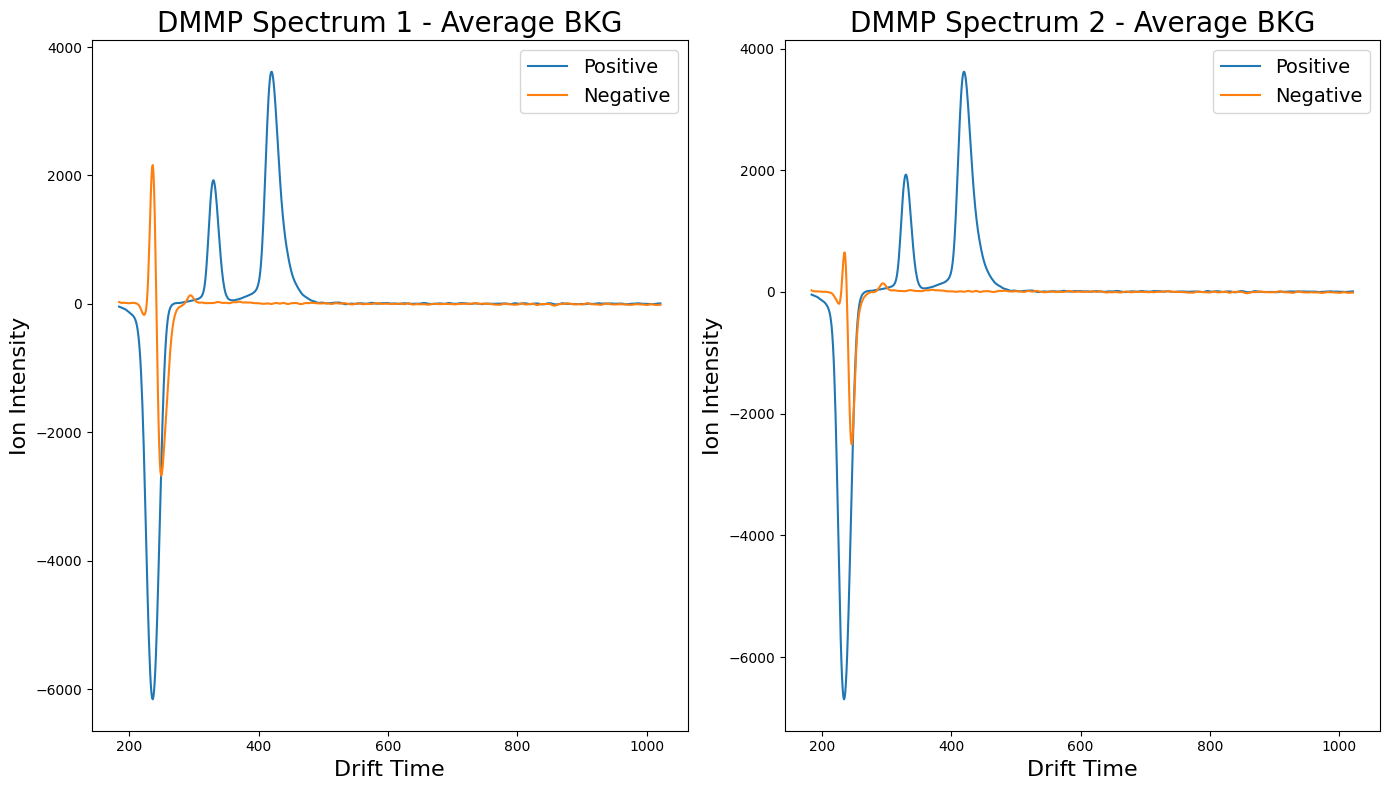

In [72]:
# plot_spectra(val_differences_df.iloc[:,1:-9], type='CARL', chem_labels=val_differences_df['Label'])
start = 38
plot_spectra(val_differences_df.iloc[start:,1:-9].reset_index(drop=True), type='Spectrum', chem_labels=list(val_differences_df['Label'])[start:])
# start = 50
# plot_spectra(val_differences_df.iloc[start:,1:-9].reset_index(drop=True), type='CARL', chem_labels=list(val_differences_df['Label'])[start:])
# start = 70
# plot_spectra(val_differences_df.iloc[start:,1:-9].reset_index(drop=True), type='CARL', chem_labels=list(val_differences_df['Label'])[start:])
# start = 90
# plot_spectra(val_differences_df.iloc[start:,1:-9].reset_index(drop=True), type='CARL', chem_labels=list(val_differences_df['Label'])[start:])

## Generating Carls Using More BKG Spectra but Only Samples of Simulant Datasets:
---
Using the entire datasets was making the data very large to work with

In [ ]:
# creating smaller samples to make carls from
n=8000
train_sample = train.sample(n=n, random_state=42).iloc[:,1:]
train_sample.reset_index(inplace=True)

val_sample = val.sample(n=int(n/3), random_state=42).iloc[:,1:]
val_sample.reset_index(inplace=True)

test_sample = test.sample(n=int(n/3), random_state=42).iloc[:,1:]
test_sample.reset_index(inplace=True)

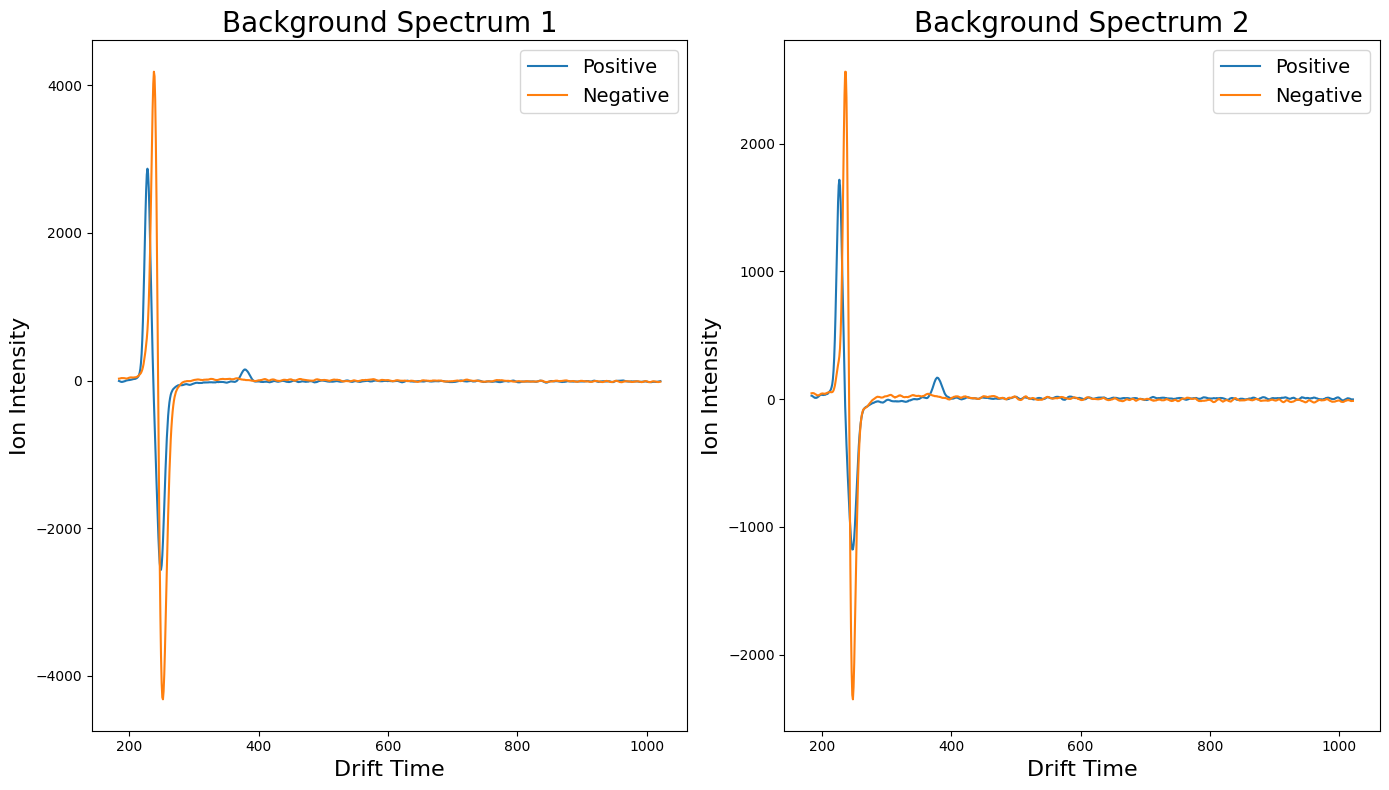

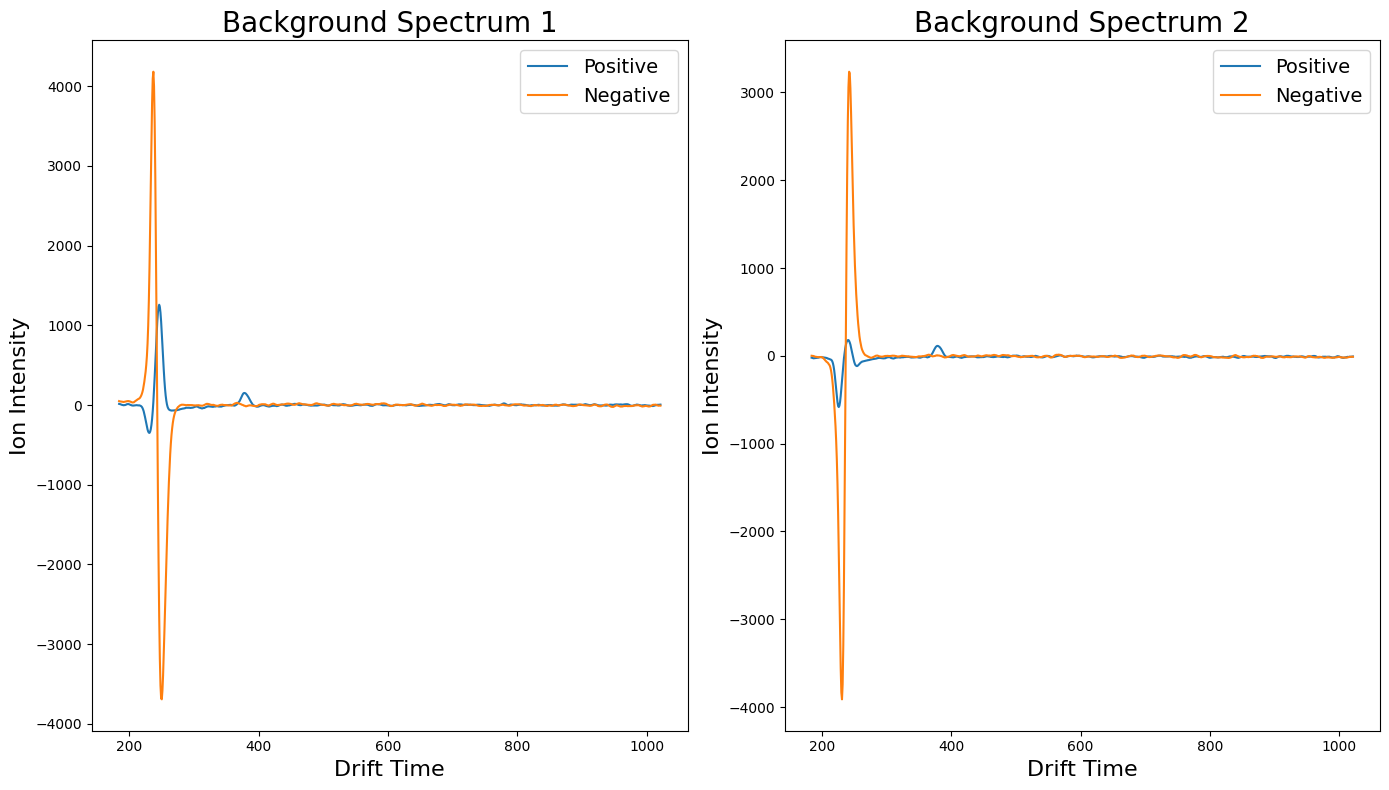

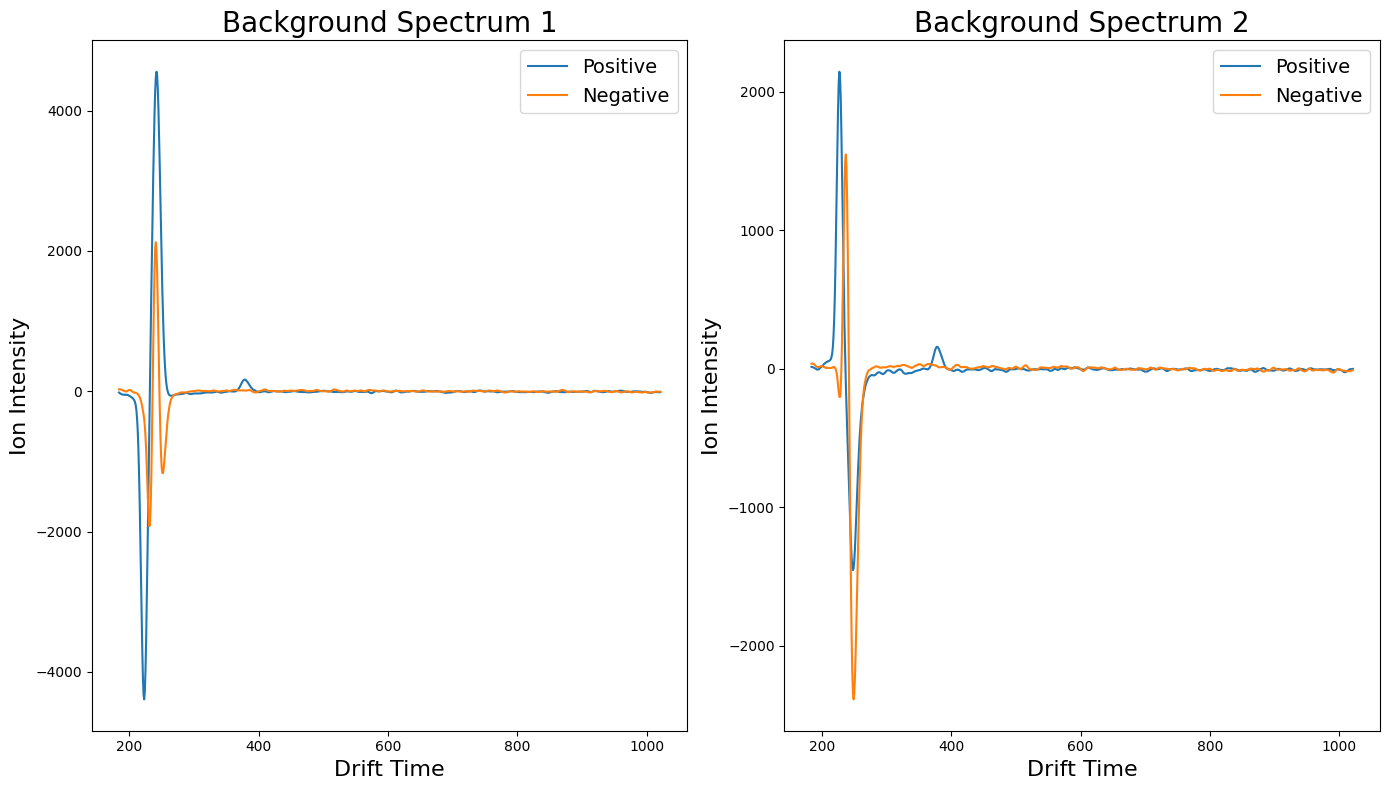

In [61]:
plot_spectra(differences_df.iloc[:,1:-9].reset_index(drop=True))
plot_spectra(differences_df.iloc[2:,1:-9].reset_index(drop=True))
plot_spectra(differences_df.iloc[4:,1:-9].reset_index(drop=True))

## Plotting:
---

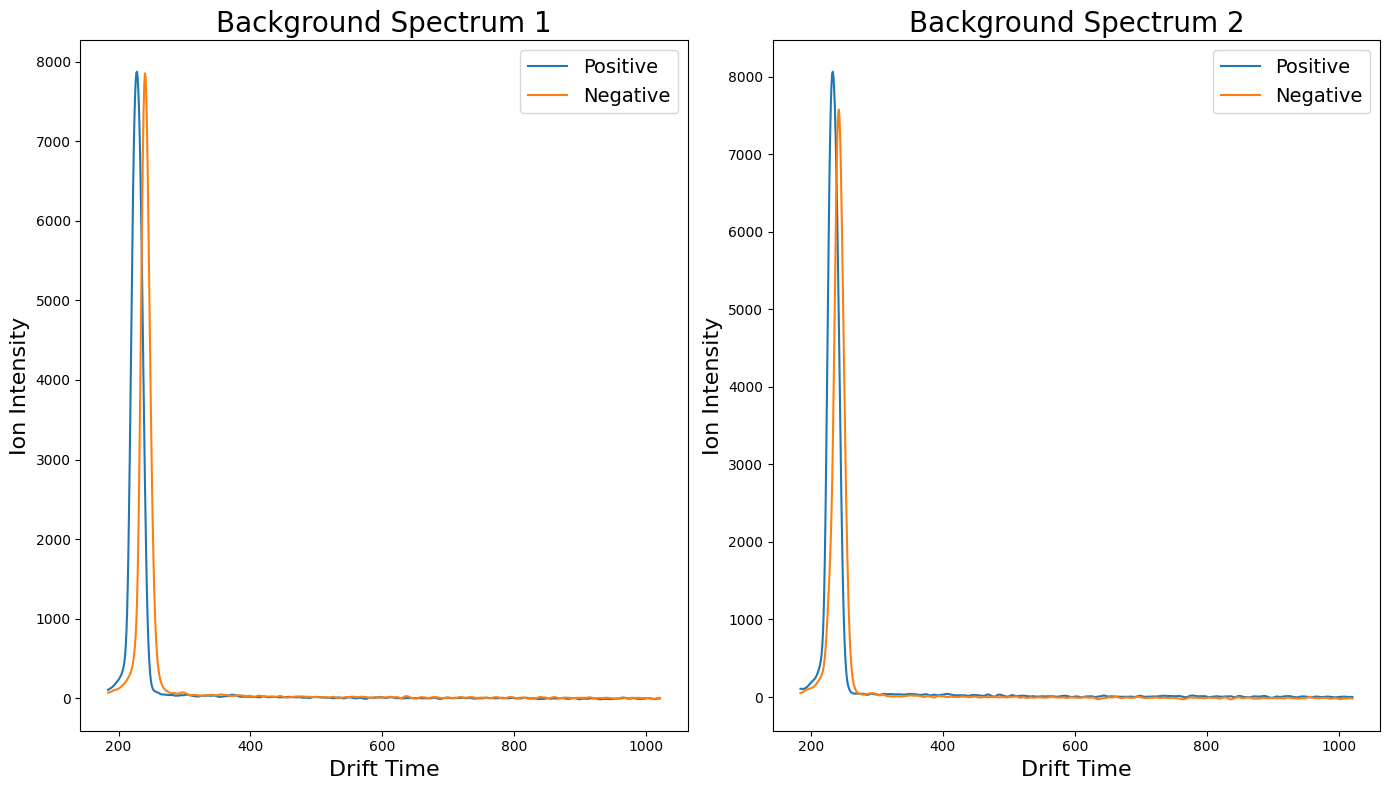

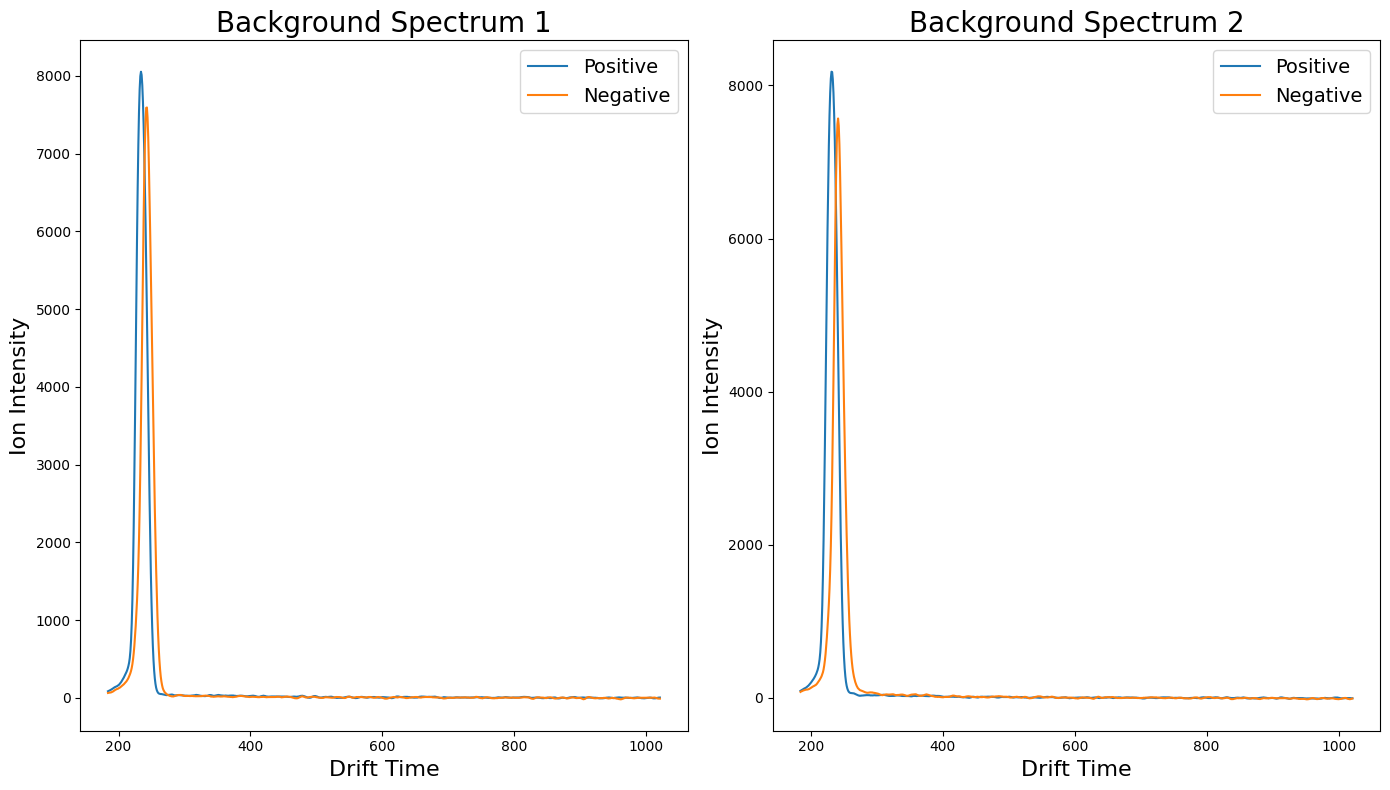

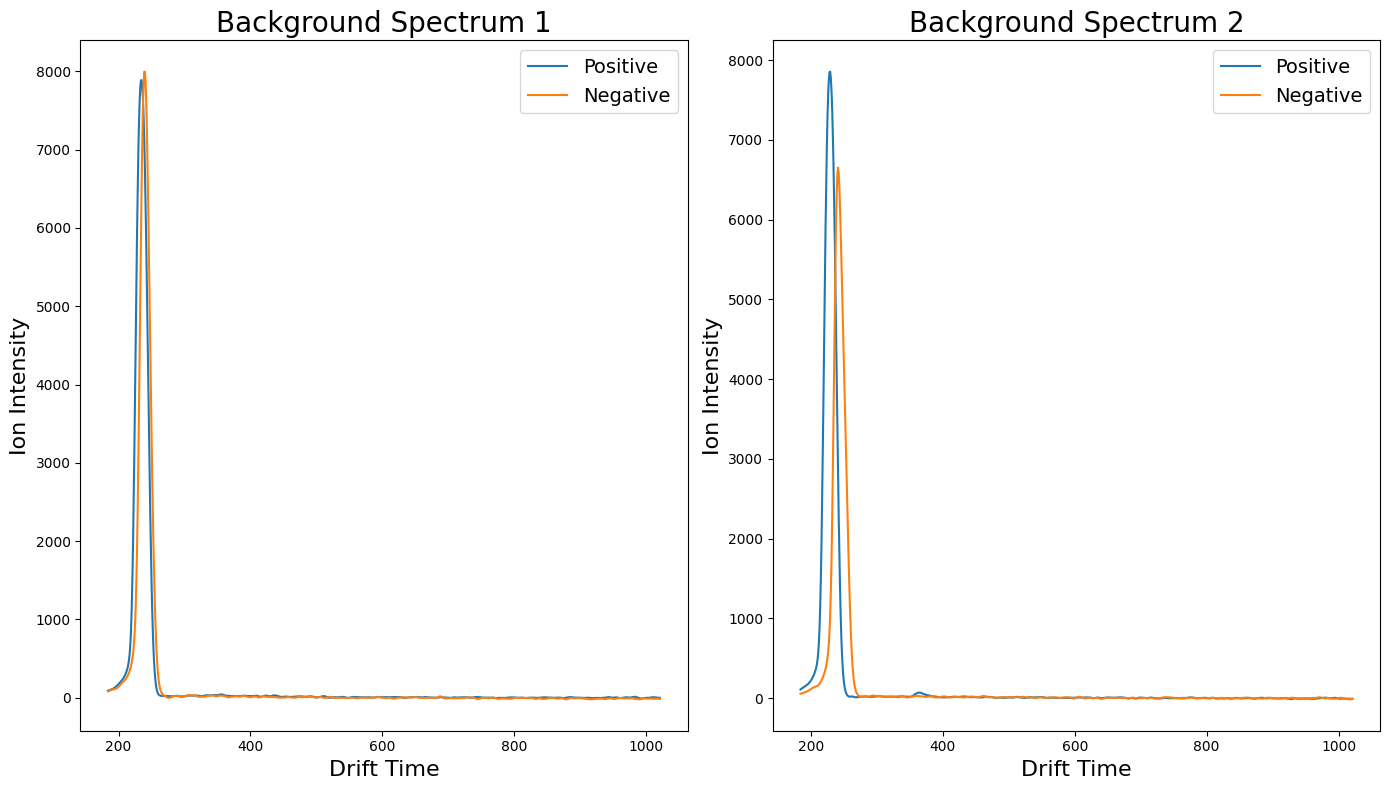

In [ ]:
plot_spectra(train_background_sample)
plot_spectra(val_background_sample)
plot_spectra(test_background_sample)

# Unused Code:
---

In [ ]:
# def generate_average_bkg_spectrum(bkg_df, n, random_state=42):
#     bkg_sample = bkg_df.sample(n=n, random_state=random_state).iloc[:,1:-1]
#     reduced_background = bkg_df.drop(bkg_sample.index)
#     bkg_sample.reset_index(inplace=True)
#     bkg_sample.drop(columns=['index'], inplace=True)

#     avg_spectrum = bkg_sample.mean()

#     return avg_spectrum, reduced_background

In [ ]:
# n = 20
# train_background_one, reduced_background = generate_average_bkg_spectrum(background, n)
# train_background_two, reduced_background = generate_average_bkg_spectrum(reduced_background, n)
# train_background_sample = pd.DataFrame([train_background_one, train_background_two])

# val_background_one, reduced_background = generate_average_bkg_spectrum(reduced_background, n)
# val_background_two, reduced_background = generate_average_bkg_spectrum(reduced_background, n)
# val_background_sample = pd.DataFrame([val_background_one, val_background_two])

# test_background_one, reduced_background = generate_average_bkg_spectrum(reduced_background, n)
# test_background_two, reduced_background = generate_average_bkg_spectrum(reduced_background, n)
# test_background_sample = pd.DataFrame([test_background_one, test_background_two])

In [ ]:
# # Convert DataFrames to PyTorch tensors
# # train_sample = train.sample(n=100000, random_state=42).iloc[:,2:-9]
# train_spectra = train.iloc[:,2:-9]
# tensor1 = torch.tensor(train_spectra.values, dtype=torch.float32)
# tensor2 = torch.tensor(background_sample.values, dtype=torch.float32)

# # Move tensors to GPU if available
# if torch.cuda.is_available():
#     tensor1 = tensor1.cuda()
#     tensor2 = tensor2.cuda()

# differences = tensor1.unsqueeze(1) - tensor2.unsqueeze(0)
# differences.shape

torch.Size([267022, 2, 1676])

In [ ]:
# differences_np = differences.cpu().numpy()  # move differences to cpu

# # Reshape the differences to 2D for DataFrame creation
# m, p, n = differences_np.shape
# differences_reshaped = differences_np.reshape(m * p, n)

# # Create a DataFrame from the reshaped array
# differences_df = pd.DataFrame(differences_reshaped)

In [ ]:
# differences_df.columns = train.columns[2:-9]
# index_col = np.repeat(train['index'].values, p)
# differences_df.insert(0, 'index', index_col)
# differences_df = pd.concat([differences_df, train.iloc[:,-9:]], axis=1)
# differences_df.head()

,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,p_192,...,n_1021,Label,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,1297539,-12.0,-14.0,-16.0,-20.0,-21.0,-22.0,-22.0,-24.0,-25.0,...,-8.0,DtBP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1297539,-12.0,-10.0,-7.0,-4.0,1.0,3.0,7.0,6.0,8.0,...,15.0,DMMP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1344903,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,-2.0,...,-7.0,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1344903,2.0,6.0,11.0,17.0,24.0,27.0,30.0,31.0,31.0,...,16.0,DtBP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1221071,10.0,12.0,15.0,14.0,17.0,19.0,22.0,23.0,26.0,...,0.0,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# def make_carl_file(data, background_spectra, file_path, n):
#     columns = list(data.columns[1:])
#     with open(file_path, mode='w', newline='') as file:
#         header_written = False
#         for idx, row in data.iterrows():
#             if idx < 3:
#                 indices = []
#                 diffs = []
#                 labels_encodings = []
#                 simulant_array = row[2:-9].values
#                 for i in range(n):
#                     background_array = background_spectra.iloc[i].values
#                     diff = simulant_array - background_array
#                     # add index, label and label encodings back in
#                     # diff = np.concatenate([[row['index']], diff, row[-9:].values])
#                     indices.append(row['index'])
#                     diffs.append(diff)
#                     labels_encodings.append(row[-9:].values)
#                 # if idx % 10 == 0:
#                 # Create a DataFrame for the current row
#                 diffs_df = pd.DataFrame(diffs)
                
#                 carl_df_chunk = pd.DataFrame(diffs_df, columns=columns)

#                 # Write chunk to CSV
#                 if not header_written:
#                     carl_df_chunk.to_csv(file, index=False, header=True)
#                     header_written = True
#                 else:
#                     carl_df_chunk.to_csv(file, index=False, header=False)

In [ ]:
def make_carl_file(data, background_spectra, file_path, n):
    columns = list(data.columns[1:])
    with open(file_path, mode='w', newline='') as file:
        header_written = False
        for idx, row in data.iterrows():
            if idx < 3:
                diffs = []
                simulant_array = row[2:-9].values
                for i in range(n):
                    background_array = background_spectra.iloc[i].values
                    diff = simulant_array - background_array
                    # add index, label and label encodings back in
                    diff = np.concatenate([[row['index']], diff, row[-9:].values])
                    diffs.append(diff)
                # Create a DataFrame for the current row                
                carl_df_chunk = pd.DataFrame(diffs, columns=columns)

                # Write chunk to CSV
                if not header_written:
                    carl_df_chunk.to_csv(file, index=False, header=True)
                    header_written = True
                else:
                    carl_df_chunk.to_csv(file, index=False, header=False)

In [59]:
# def make_carl_file(data, background_spectra, file_path, n):
#     diffs = []
#     for idx, row in data.iterrows():
#         if idx < 10:
#             simulant_array = row[2:-9].values
#             for i in range(n):
#                 background_array = background_spectra.iloc[i].values
#                 diff = simulant_array - background_array
#                 # add index, label and label encodings back in
#                 diff = np.concatenate([[row['index']], diff, row[-9:].values])
#                 diffs.append(diff)

#     columns = list(data.columns[1:])
#     carl_df = pd.DataFrame(diffs, columns=columns)
#     carl_df.to_csv(file_path, index=False)

In [102]:
# start_time = time.time()    
# n = 2
# make_carl_file(train, background_sample, file_path='/mnt/usb/cmdunham/preprocessed_ims_data/train_carls.csv', n=n)
# # make_carl_file(val, background_sample, file_path='/mnt/usb/cmdunham/preprocessed_ims_data/val_carls.csv', n=n)
# # make_carl_file(test, background_sample, file_path='/mnt/usb/cmdunham/preprocessed_ims_data/test_carls.csv', n=n)

# end_time = time.time()
# print('Total run time: ', end_time - start_time)

In [103]:
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_carls.csv'
carls = pd.read_csv(file_path)
carls.head()

,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,p_192,...,n_1021,Label,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,655550,-9.0,-11.0,-15.0,-22.0,-26.0,-29.0,-32.0,-35.0,-39.0,...,-7.0,DEB,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,384167,-9.0,-10.0,-9.0,-12.0,-13.0,-14.0,-17.0,-21.0,-25.0,...,-9.0,DEM,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1141374,-19.0,-19.0,-20.0,-23.0,-25.0,-28.0,-32.0,-37.0,-42.0,...,-12.0,DMMP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1317186,-1.0,0.0,2.0,2.0,3.0,6.0,6.0,7.0,5.0,...,-5.0,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1110674,-26.0,-27.0,-28.0,-28.0,-30.0,-31.0,-34.0,-39.0,-44.0,...,-1.0,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
